# Workaround bug

In [ ]:
!pip install numba-cuda==0.4.0
from numba import config

config.CUDA_ENABLE_PYNVJITLINK = 1

# Librerías y detección de GPUs

In [ ]:
import numpy as np
from numba import cuda
import numba
import math
import string
import matplotlib.pyplot as plt
from skimage import data, io
import requests
from time import perf_counter

cuda.gpus
cuda.detect()
cuda.select_device(0)

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-4b6579a9-5126-3e40-218c-23ec2f2d2ac0
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


<weakproxy at 0x7a9efe9f27a0 to Device at 0x7a9efe9cc880>

# Cantidad de SMs y Cores

In [ ]:
cc_cores_per_SM_dict = {  (2,0) : 32,  (2,1) : 48, (3,0) : 192, (3,5) : 192, (3,7) : 192, (5,0) : 128, (5,2) : 128, (6,0) : 64, (6,1) : 128, (7,0) : 64, (7,5) : 64, (8,0) : 64, (8,6) : 128, (8,9) : 128, (9,0) : 128 }
device = cuda.get_current_device()
sms = getattr(device, "MULTIPROCESSOR_COUNT")
cc = device.compute_capability
cores_per_sm = cc_cores_per_SM_dict.get(cc)
num_cores = cores_per_sm * sms
print("GPU compute capability: ", cc)
print("Número de SM: ", sms)
print("Número de cores: ", num_cores)

GPU compute capability:  (7, 5)
Número de SM:  40
Número de cores:  2560


# Atributos relevantes del GPU

In [ ]:
from numba.cuda.cudadrv import enums

device = cuda.get_current_device()
attribs = [name.replace("CU_DEVICE_ATTRIBUTE_", "") for name in dir(enums) if name.startswith("CU_DEVICE_ATTRIBUTE_")]
for attr in attribs:
    print(attr, "=", getattr(device, attr))

ASYNC_ENGINE_COUNT = 3
CAN_MAP_HOST_MEMORY = 1
CAN_USE_HOST_POINTER_FOR_REGISTERED_MEM = 1
CLOCK_RATE = 1590000
COMPUTE_CAPABILITY_MAJOR = 7
COMPUTE_CAPABILITY_MINOR = 5
COMPUTE_MODE = 0
COMPUTE_PREEMPTION_SUPPORTED = 1
CONCURRENT_KERNELS = 1
CONCURRENT_MANAGED_ACCESS = 1
COOPERATIVE_LAUNCH = 1
COOPERATIVE_MULTI_DEVICE_LAUNCH = 1
ECC_ENABLED = 1
GLOBAL_L1_CACHE_SUPPORTED = 1
GLOBAL_MEMORY_BUS_WIDTH = 256
GPU_OVERLAP = 1
HOST_NATIVE_ATOMIC_SUPPORTED = 0
INTEGRATED = 0
IS_MULTI_GPU_BOARD = 0
KERNEL_EXEC_TIMEOUT = 0
L2_CACHE_SIZE = 4194304
LOCAL_L1_CACHE_SUPPORTED = 1
MANAGED_MEMORY = 1
MAX_BLOCK_DIM_X = 1024
MAX_BLOCK_DIM_Y = 1024
MAX_BLOCK_DIM_Z = 64
MAX_GRID_DIM_X = 2147483647
MAX_GRID_DIM_Y = 65535
MAX_GRID_DIM_Z = 65535
MAX_MAX_TEXTURE_2D_MIPMAPPED_HEIGHT = 32768
MAX_PITCH = 2147483647
MAX_REGISTERS_PER_BLOCK = 65536
MAX_REGISTERS_PER_MULTIPROCESSOR = 65536
MAX_SHARED_MEMORY_PER_BLOCK = 49152
MAX_SHARED_MEMORY_PER_BLOCK_OPTIN = 65536
MAX_SHARED_MEMORY_PER_MULTIPROCESSOR = 65536
MAX_S

# Lanzamiento de un Kernel simplista para un Vector Ad-hoc

In [ ]:
@cuda.jit
def a_kernel(my_array):
  """
  Aquí iría el código de mi kernel
  """
  pass

my_array = np.ones(320)
# hilos por bloque debe estar en función del warp size
threads_per_block = 32
# número de bloques en la rejilla
my_grid  = my_array.size // threads_per_block
a_kernel[my_grid, threads_per_block](my_array)


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


# Posición de los Hilos relativa a los Datos para un Vector Genérico y copiar vectores al Device

In [ ]:
@cuda.jit
def multiplier_kernel(my_array, structure):
  position = cuda.threadIdx.x + cuda.blockIdx.x*cuda.blockDim.x
  if position < my_array.size:
    my_array[position] *= 2
    structure[position][0] = position
    structure[position][1] = cuda.threadIdx.x
    structure[position][2] = cuda.blockIdx.x
    structure[position][3] = cuda.blockDim.x

VECTOR_SIZE = 321
my_array = np.ones(VECTOR_SIZE)
# Copiar arreglo al device
device_array = cuda.device_array_like(my_array)

VARS_TO_DEBUG = 4;
structure = np.zeros(shape=(VECTOR_SIZE, VARS_TO_DEBUG))

threads_per_block = 32

# número de bloques en la rejilla
my_grid = math.ceil(my_array.size / threads_per_block)
my_grid

multiplier_kernel[my_grid, threads_per_block](my_array, structure)
print(my_array)
for step in structure:
  print(step)


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 11 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[ 0.  0.  0. 32.]
[ 1.

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


# Cálculo rápido de la posición del hilo & Debugging de un programa en CUDA

In [ ]:
@cuda.jit
def multiplier_kernel(my_array, structure):
  position = cuda.threadIdx.x + cuda.blockIdx.x*cuda.blockDim.x
  if position < my_array.size:
    my_array[position] *= 2
    structure[position][0] = position
    structure[position][1] = cuda.threadIdx.x
    structure[position][2] = cuda.blockIdx.x
    structure[position][3] = cuda.blockDim.x

my_array = np.ones(321)
device_array = cuda.device_array_like(my_array)
structure = np.zeros(shape=(321, 4))
threads_per_block = 32
my_grid = math.ceil(my_array.size / threads_per_block)
multiplier_kernel[my_grid, threads_per_block](my_array, structure)
print(my_array)
for step in structure:
  print(step)


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 11 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[ 0.  0.  0. 32.]
[ 1.

# Suma de vectores optimizada con copias al device

In [ ]:
@cuda.jit
def sum_kernel(a, b, c):
  position = cuda.grid(1)
  if position < a.size:
    c[position] = a[position] + b[position]

VECTOR_SIZE = 321
a = np.ones(VECTOR_SIZE)
b = np.ones(VECTOR_SIZE)
c = np.zeros(VECTOR_SIZE)

# Copiando al device
device_a = cuda.to_device(a)
device_b = cuda.to_device(b)
#device_c = cuda.device_array_like(c)
device_c = cuda.device_array(VECTOR_SIZE)


threads_per_block = 32
my_grid = math.ceil(a.size / threads_per_block)
sum_kernel[my_grid, threads_per_block](device_a, device_b, device_c)

print(device_c.copy_to_host())

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 11 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]


# Suma de matrices con grid de una sola dimensión
## Rejilla asociada a los renglones

In [ ]:
np.set_printoptions(suppress=True)

@cuda.jit
def addition_matrix_kernel(a, b, c):
  i = cuda.grid(1)
  if i < a.shape[0]:
    for j in range(a.shape[1]):
      c[i][j] = a[i][j] + b[i][j]

ROWS = 64
COLUMNS = 128
host_a = np.arange(ROWS*COLUMNS).reshape((ROWS, COLUMNS))
host_b = np.arange(ROWS*COLUMNS).reshape((ROWS, COLUMNS))
host_c = np.zeros(shape=(ROWS, COLUMNS))

dev_a = cuda.to_device(host_a)
dev_b = cuda.to_device(host_b)
dev_c = cuda.device_array_like(host_c)

threads_per_block = 32
my_grid = math.ceil(ROWS / threads_per_block)
print(my_grid, threads_per_block)
addition_matrix_kernel[my_grid, threads_per_block](dev_a, dev_b, dev_c)
print(dev_c.copy_to_host())

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


2 32
[[    0.     2.     4. ...   250.   252.   254.]
 [  256.   258.   260. ...   506.   508.   510.]
 [  512.   514.   516. ...   762.   764.   766.]
 ...
 [15616. 15618. 15620. ... 15866. 15868. 15870.]
 [15872. 15874. 15876. ... 16122. 16124. 16126.]
 [16128. 16130. 16132. ... 16378. 16380. 16382.]]


# Suma de matrices con grid de una sola dimensión
## Rejilla asociada a las columnas

In [ ]:
np.set_printoptions(suppress=True)

@cuda.jit
def addition_matrix_kernel(a, b, c):
  j = cuda.grid(1)
  if j < a.shape[1]:
    for i in range(a.shape[0]):
      c[i][j] = a[i][j] + b[i][j]

ROWS = 64
COLUMNS = 129
host_a = np.arange(ROWS*COLUMNS).reshape((ROWS, COLUMNS))
host_b = np.arange(ROWS*COLUMNS).reshape((ROWS, COLUMNS))
host_c = np.zeros(shape=(ROWS, COLUMNS))

dev_a = cuda.to_device(host_a)
dev_b = cuda.to_device(host_b)
dev_c = cuda.device_array_like(host_c)

threads_per_block = 32
my_grid = math.ceil(COLUMNS / threads_per_block)
print(my_grid, threads_per_block)
addition_matrix_kernel[my_grid, threads_per_block](dev_a, dev_b, dev_c)
print(dev_c.copy_to_host())

5 32


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[[    0.     2.     4. ...   252.   254.   256.]
 [  258.   260.   262. ...   510.   512.   514.]
 [  516.   518.   520. ...   768.   770.   772.]
 ...
 [15738. 15740. 15742. ... 15990. 15992. 15994.]
 [15996. 15998. 16000. ... 16248. 16250. 16252.]
 [16254. 16256. 16258. ... 16506. 16508. 16510.]]


# Suma de Matrices

In [ ]:
import math
import numpy as np
from numba import cuda

@cuda.jit
def matrix_addition(A, B, C):
  row = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  col = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  #row, col = cuda.grid(2)
  if row < C.shape[0] and col < C.shape[1]:
    C[row][col] = A[row][col] + B[row][col]

ROWS = 320
COLUMNS = 1280
host_a = np.full((ROWS, COLUMNS), 2, float)
host_b = np.full((ROWS, COLUMNS), 4, float)

dev_a = cuda.to_device(host_a)
dev_b = cuda.to_device(host_b)
dev_c = cuda.device_array((ROWS, COLUMNS))

# 16 * 32 = 512 threads
threads_per_block = (16, 32)
blocks_x = math.ceil(ROWS / threads_per_block[0])
blocks_y = math.ceil(COLUMNS / threads_per_block[1])
grid = (blocks_x, blocks_y)
print(grid)
matrix_addition[grid, threads_per_block](dev_a, dev_b, dev_c)

print(dev_c.copy_to_host())

(20, 40)
[[6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]
 ...
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]]


# Multiplicación de Matrices

In [ ]:
import math
import numpy as np
from numba import cuda

@cuda.jit
def matrix_multiplication(A, B, C):
  row, col = cuda.grid(2)
  if row < C.shape[0] and col < C.shape[1]:
    sum = 0
    for k in range(A.shape[1]):
      sum += A[row][k] * B[k][col]
    C[row][col] = sum

host_a = np.full((32, 12), 2, float)
host_b = np.full((12, 48), 4, float)
host_c = np.full((32, 48), 0, float)

dev_a = cuda.to_device(host_a)
dev_b = cuda.to_device(host_b)
dev_c = cuda.device_array((32, 48))

threads_per_block = (16, 32)
blocks_x = math.ceil(host_c.shape[0] / threads_per_block[0])
blocks_y = math.ceil(host_c.shape[1] / threads_per_block[1])
grid = (blocks_x, blocks_y)
print(grid)
matrix_multiplication[grid, threads_per_block](dev_a, dev_b, dev_c)

print(dev_c.copy_to_host())

(2, 2)
[[96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]
 ...
 [96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]]


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


# Aplicación de filtro a Imagen

1.0 255.0 [[ 18.  17.  17. ... 126. 126. 123.]
 [ 21.  21.  22. ... 128. 127. 124.]
 [ 25.  26.  27. ... 130. 129. 125.]
 ...
 [ 67.  56.  51. ...  68.  65.  63.]
 [ 67.  61.  55. ...  76.  73.  69.]
 [ 69.  65.  64. ...  75.  80.  78.]]


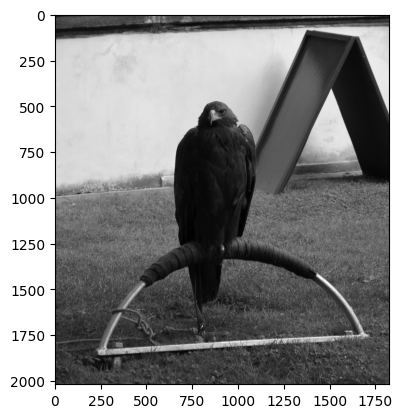

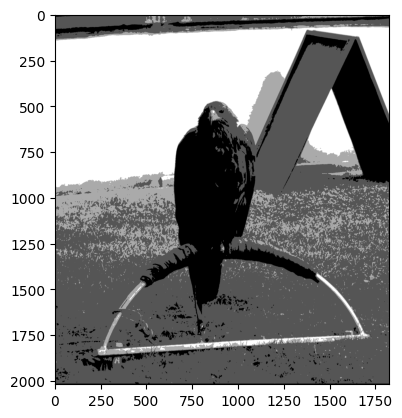

In [ ]:
from numba import cuda
import matplotlib.pyplot as plt
from skimage import data, io
import math
import numpy as np

@cuda.jit
def conv(pixels, output, size):
    row, col = cuda.grid(2)
    if (row + 2) < size[0] and (col + 2) < size[1] and row > 2 and col > 2:
      divisor = 75
      sum = pixels[row-2][col-1]/divisor + pixels[row-2][col]/divisor + pixels[row-2][col+1]/divisor + \
            pixels[row-1][col-1]/divisor + pixels[row-1][col]/divisor + pixels[row-1][col+1]/divisor + \
            pixels[row-0][col-1]/divisor + pixels[row-0][col]/divisor + pixels[row-0][col+1]/divisor + \
            pixels[row+1][col-1]/divisor + pixels[row+1][col]/divisor + pixels[row+1][col+1]/divisor + \
            pixels[row+2][col-1]/divisor + pixels[row+2][col]/divisor + pixels[row+2][col+1]/divisor
      output[row][col] = round(sum/15)


#eagle = data.eagle().astype(np.float32)
eagle = io.imread("eagle.png").astype(np.float32)
print(eagle.min(), eagle.max(), eagle)
plt.imshow(eagle, cmap="gray")
plt.show()

##(2019, 1826)
host_pixels = eagle
device_pixels = cuda.to_device(host_pixels)
device_output = cuda.device_array(host_pixels.shape)


threads_per_block = (16, 16)
blocks_x = math.ceil(eagle.shape[0] / threads_per_block[0])
blocks_y = math.ceil(eagle.shape[1] / threads_per_block[1])
grid = (blocks_x, blocks_y)

conv[grid, threads_per_block](device_pixels, device_output, eagle.shape)
plt.imshow(device_output.copy_to_host(), cmap="gray")
plt.show()


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>